In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

# CXR Modality-specific pretraining

data used: Pediatric pneumonia CXR and Indiana CXR


During this training step, the combined CXR collection, including RSNA CXR, pediatric
pneumonia CXR, and Indiana CXR datasets, is split at the patient-level into 80%
for training and 20% for testing. With a fixed seed value, we allocated 10% of the training
data toward model validation.

In [3]:
import glob
filename = glob.glob(r'../../dataset/TBNTBN/train/TB/*.*')
print(len(filename))
filename = glob.glob(r'../../dataset/TBNTBN/train/NTB/*.*')
print(len(filename))
filename = glob.glob(r'../../dataset/TBNTBN/train/NORM/*.*')
print(len(filename))


4850
7675
5717


In [3]:
import cv2
import os
import datetime
import time
import numpy as np

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing  import image_dataset_from_directory
from tensorflow.keras.layers import Input,UpSampling3D,Dense, Dropout,BatchNormalization 
from tensorflow.keras.layers import SeparableConv2D, Activation,DepthwiseConv2D,Flatten,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

train_dir = '../../dataset/TBNTBN/train/'

In [13]:
def create_dataset(img_folder):
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        i = 0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path)
            if image is not None:
                image=cv2.resize(image, IMG_SIZE,interpolation = cv2.INTER_CUBIC)
                image=np.array(image)
                image = image.astype('float32')
#                 image /= 255 
                img_data_array.append(image)
                class_name.append(dir1)
            i += 1
            if i%500 == 0:
                print('loading {}th image for class {}'.format(i,str(dir1)))
    return np.array(img_data_array,np.float32), class_name

img_data, class_name =create_dataset(train_dir)

loading 100th image for class TB
loading 200th image for class TB
loading 300th image for class TB
loading 400th image for class TB
loading 500th image for class TB
loading 600th image for class TB
loading 700th image for class TB
loading 800th image for class TB
loading 900th image for class TB
loading 1000th image for class TB
loading 1100th image for class TB
loading 1200th image for class TB
loading 1300th image for class TB
loading 1400th image for class TB
loading 1500th image for class TB
loading 1600th image for class TB
loading 1700th image for class TB
loading 1800th image for class TB
loading 1900th image for class TB
loading 2000th image for class TB
loading 2100th image for class TB
loading 2200th image for class TB
loading 2300th image for class TB
loading 2400th image for class TB
loading 2500th image for class TB
loading 2600th image for class TB
loading 2700th image for class TB
loading 2800th image for class TB
loading 2900th image for class TB
loading 3000th image fo

In [22]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
target_val = enc.fit_transform(class_name)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(img_data, ), 
                                                    target_val, 
                                                    test_size=0.20,
                                                    random_state=42)



In [24]:
def build_model(input_shape):
    inputs = Input(shape=input_shape, name="input_image")
    mobilenetv2 = tf.keras.applications.MobileNetV2(
        input_tensor = inputs, 
        weights="imagenet", include_top=False, alpha=0.35)
    
    x = mobilenetv2.get_layer('out_relu').output
    x = GlobalAveragePooling2D(name='gap')(x)
    output = Dense(3,activation='softmax')(x)
    return tf.keras.Model(inputs,output)


In [25]:
model = build_model(input_shape=(256,256,3))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
model.summary() 

Metal device set to: Apple M1


2022-07-29 16:01:22.432380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-29 16:01:22.433153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [26]:
# tf.keras.utils.plot_model(model, "without_sincnet.png", show_shapes=True)

In [27]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# callback = [
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=1e-8 ),
#     tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#     tf.keras.callbacks.ModelCheckpoint(
#         filepath='../../output/checkpoints/mobilenetv2/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#         save_best_only=True,save_weights_only=True,verbose=1)
#            ]

In [56]:
history = model.fit(x=X_train, 
                    y = y_train,
                    epochs=25,
                    batch_size = 16,
                    validation_split=0.1
                              )
#                    callbacks=callback)


Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-29 14:29:55.736323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


821/821 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8295WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x179f441f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-29 14:32:09.491122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


821/821 [==============================] - 139s 166ms/step - loss: 0.4828 - accuracy: 0.8295 - val_loss: 0.5275 - val_accuracy: 0.7938
Epoch 2/25
821/821 [==============================] - 141s 171ms/step - loss: 0.2250 - accuracy: 0.9257 - val_loss: 0.1878 - val_accuracy: 0.9370
Epoch 3/25
821/821 [==============================] - 138s 168ms/step - loss: 0.1699 - accuracy: 0.9447 - val_loss: 0.1218 - val_accuracy: 0.9596
Epoch 4/25
821/821 [==============================] - 142s 172ms/step - loss: 0.1370 - accuracy: 0.9520 - val_loss: 0.0994 - val_accuracy: 0.9664
Epoch 5/25
821/821 [==============================] - 139s 169ms/step - loss: 0.1211 - accuracy: 0.9583 - val_loss: 0.0846 - val_accuracy: 0.9719
Epoch 6/25
821/821 [==============================] - 137s 167ms/step - loss: 0.1010 - accuracy: 0.9680 - val_loss: 0.0792 - val_accuracy: 0.9719
Epoch 7/25
821/821 [==============================] - 142s 173ms/step - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.0729 - val_accura

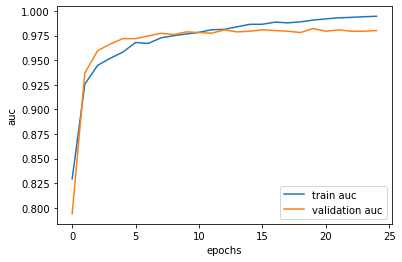

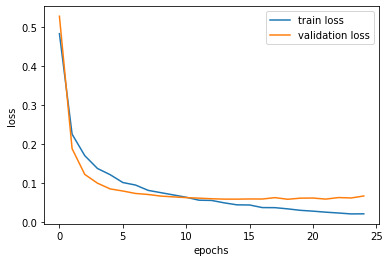

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train auc','validation auc'])
plt.ylabel('auc')
plt.xlabel('epochs')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history[ 'val_loss'])
plt.legend(['train loss','validation loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()


In [28]:
model = build_model(input_shape=(256,256,3))
model.load_weights('../../output/checkpoints/mobilenetv2/weights.22-0.06.hdf5')
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])


In [29]:
model.evaluate(X_test,y_test)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-29 16:01:27.889937: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-29 16:01:27.890997: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-29 16:01:28.148812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 10s 80ms/step - loss: 0.0952 - accuracy: 0.9945


[0.09521837532520294, 0.994519054889679]

In [30]:
predictions = model.predict(X_test)
# predictions = predictions.reshape(138,3)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-29 16:01:39.340502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [65]:
predictions

array([[1.2449983e-05, 3.0550327e-06, 9.9998450e-01],
       [2.5342029e-02, 9.7464937e-01, 8.6943674e-06],
       [9.8450869e-01, 1.5429992e-02, 6.1318744e-05],
       ...,
       [4.0638010e-04, 3.1226598e-06, 9.9959058e-01],
       [3.3472281e-06, 6.6793032e-06, 9.9998999e-01],
       [9.9999630e-01, 3.2854955e-06, 3.7568356e-07]], dtype=float32)

In [31]:
pred = np.zeros((y_test.shape[0]))
for i,p in enumerate(predictions):
    l = np.argmax(p)
    pred[i] = l
    

In [32]:
# predictions = [int(xx[0]<xx[1]) for xx in predictions]
y = [np.argmax(yy) for yy in y_test]


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y,pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1126
           1       1.00      0.99      1.00      1576
           2       0.99      1.00      0.99       947

    accuracy                           0.99      3649
   macro avg       0.99      0.99      0.99      3649
weighted avg       0.99      0.99      0.99      3649



In [34]:
import pandas as pd
df = pd.DataFrame({'ytrue':y,'pred':pred})
print(df['ytrue'].value_counts())
print(df['pred'].value_counts())


1    1576
0    1126
2     947
Name: ytrue, dtype: int64
1.0    1566
0.0    1129
2.0     954
Name: pred, dtype: int64


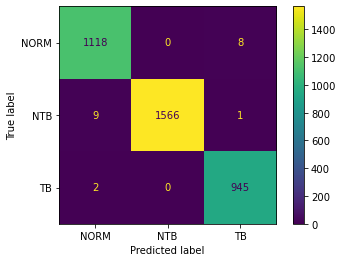

In [36]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y,pred,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORM','NTB','TB'])
disp.plot()
plt.show()


In [37]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_cam_heatmap(img_array,model, layer_name,cam_path="cam.jpg"):
    
        #Get the 128 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]

        get_output = K.function(
            [model.input], 
            [model.get_layer(layer_name).output, model.output])
        
        [conv_outputs, predictions] = get_output([img_array])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        
        for i,w in enumerate(class_weights[:, 0]):
            cam += w * conv_outputs[:, :, i]
            
        cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)

        return cam.numpy()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    grads=grads[0,:,:,:]

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.math.multiply(last_conv_layer_output,grads)
    heatmap = tf.reduce_sum(heatmap,axis=-1)
#     heatmap = tf.keras.layers.Sigmoid()(heatmap)

    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [38]:
def save_and_display_gradcam(img, heatmap, pos, cam_path="cam.jpg", alpha=0.4,title='input'):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    plt.subplot(10,2,pos)
    plt.title(title)
    plt.imshow(superimposed_img)



In [39]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [50]:
model = build_model(input_shape=(256,256,3))
model.load_weights('../../output/checkpoints/mobilenetv2/weights.22-0.06.hdf5')
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])



1 [2.3339947e-03 7.3978648e-05 9.9759209e-01]
2 [9.9998701e-01 1.3037077e-05 2.4991552e-08]
3 [9.9983054e-01 1.6939800e-04 1.6801371e-07]
4 [2.0192072e-05 1.1221119e-05 9.9996865e-01]
5 [1.0984742e-04 3.9579165e-05 9.9985051e-01]
6 [6.4369226e-05 9.9987650e-01 5.9089114e-05]
7 [9.9976844e-01 2.1835296e-04 1.3259866e-05]
8 [1.8380964e-03 9.9811614e-01 4.5814802e-05]
9 [2.4711716e-04 5.9627851e-06 9.9974698e-01]
10 [1.4365077e-01 8.5624093e-01 1.0823395e-04]


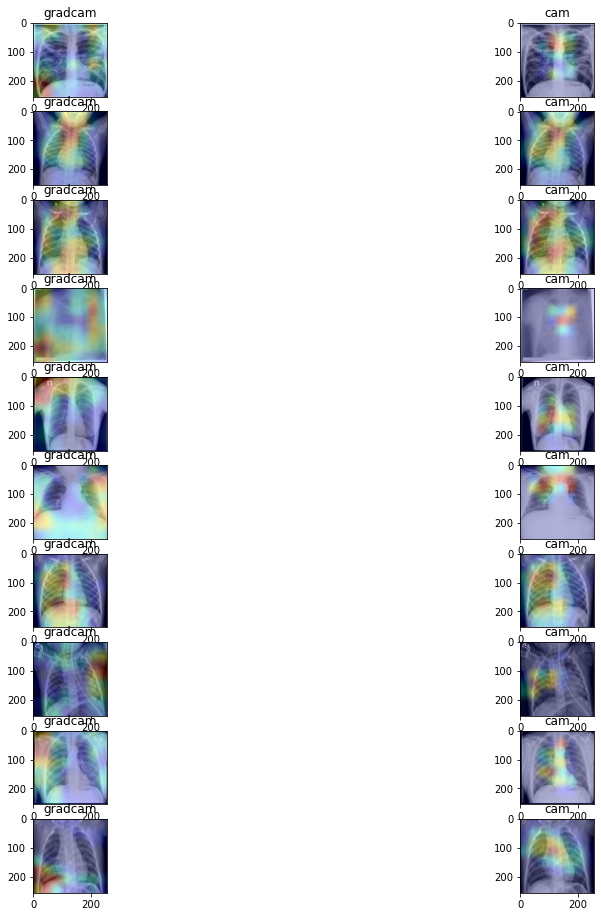

In [58]:
plt.figure(figsize=(16, 16))

for count in range(1,11):#(len(filename)):
#     im = cv2.imread(filename[count])
#     im = cv2.resize(im, (256,256), interpolation = cv2.INTER_AREA)
#     img = tf.keras.preprocessing.image.load_img(
#         filename[count],
#         color_mode='rgb', 
#         target_size=(256, 256))
#     img = tf.keras.preprocessing.image.img_to_array(img)
    img = X_test[count+10]
    im = img
    img = np.reshape(img,(1,256,256,3))
    print(count,max(model.predict(img)))
   
    heatmap_cam = make_cam_heatmap(img, model, 'out_relu')
    heatmap_gradcam = make_gradcam_heatmap(img, model, 'out_relu')
    save_and_display_gradcam(im, heatmap_gradcam,2*count-1,title='gradcam')
    save_and_display_gradcam(im, heatmap_cam,2*count,title='cam')
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-29 16:24:41.023118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


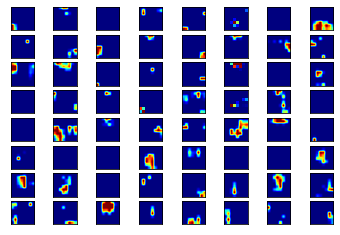

In [56]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'out_relu'

mdl = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = load_img(filename[1], target_size=(256, 256))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = preprocess_input(image)

# Apply the model to the image
feature_maps = mdl.predict(image)

square = 8
index = 1
for _ in range(square):
    for _ in range(square):
        
        ax = plt.subplot(square, square, index)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(feature_maps[0, :, :, index-1], cmap='jet')
        index += 1
        
plt.show()